In [2]:
#necessary on linux/mac
#import multiprocessing

#if __name__ == '__main__':
#    multiprocessing.set_start_method('forkserver')

In [28]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

import datetime
import matplotlib
from matplotlib import pyplot

In [29]:
import sys
from fastai.imports import *
from fastai.structured import *

In [30]:
prediction_trend_data = [] 
input_numeric_columns = []
input_categorical_columns = []
output_columns = []

normalize = False
dfOriginal = pd.read_csv('../Data/V1.1FeaturesWithLabelsTestRegion220131201To20180430.csv', parse_dates=['Date'], low_memory=False)
df = dfOriginal
all_columns = list(df)
numeric_regex = re.compile("n_*")
input_numeric_columns = list(filter(numeric_regex.match, all_columns))
categorical_regex = re.compile("c_*")                               
input_categorical_columns = list(filter(categorical_regex.match, all_columns))
output_regex = re.compile("o_*")                               
output_columns = list(filter(output_regex.match, all_columns))
metadata_columns = ["Lat", "Lon", "UnifiedRegion", "Date"]
df = df[input_numeric_columns+input_categorical_columns+output_columns+prediction_trend_data+metadata_columns]
    

In [31]:
df = df[df['o_Day1DangerAboveTreeline']!='no-data']
df = df[df['o_Day1DangerNearTreeline']!='no-data']
df = df[df['o_Day1DangerBelowTreeline']!='no-data']

df = df[df['o_Day1DangerAboveTreeline']!='Extreme']
df = df[df['o_Day1DangerNearTreeline']!='Extreme']
df = df[df['o_Day1DangerBelowTreeline']!='Extreme']

In [32]:
#clean mising values
mappingMissingValues = {-9999:np.nan}
df = df.replace(mappingMissingValues)

df = df.interpolate(method='linear', axis=0).ffill().bfill()


In [33]:
train_cats(df)
df['o_Day1DangerAboveTreeline'].cat.set_categories(['High', 'Considerable', 'Moderate', 'Low'], ordered=True, inplace=True)

In [46]:
splitBySeason = True
testAsMostRecent = False
yColumns = ['o_Day1DangerAboveTreeline']
yNearColumn = ['o_Day1DangerNearTreeline']
yBelowColumn = ['o_Day1DangerBelowTreeline']

if(splitBySeason):
    if(testAsMostRecent):
        df_train = df[df['Date'] < datetime.datetime(2017, 5, 1)] 
        df_test = df[df['Date'] > datetime.datetime(2017, 5, 1)]
    else:
        df_train = df[(df['Date'] < datetime.datetime(2016, 5, 1)) | (df['Date'] > datetime.datetime(2017, 5, 1))] 
        df_test = df[(df['Date'] > datetime.datetime(2016, 5, 1)) & (df['Date'] < datetime.datetime(2017, 5, 1))]
    
    y_Above_train = df_train[yColumns + metadata_columns]
    y_Near_train = df_train[yNearColumn + metadata_columns]
    y_Below_train = df_train[yBelowColumn + metadata_columns]
    
    y_Above_test = df_test[yColumns + metadata_columns]
    y_Near_test = df_test[yNearColumn + metadata_columns]
    y_Below_test = df_test[yBelowColumn + metadata_columns]
    
    #feature engineer date
    add_datepart(df_train, 'Date')
    add_datepart(df_test, 'Date')
    date_columns = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed']
    
    #same x input trained to get a different output
    X_Above_train = X_Near_train = X_Below_train = df_train[input_numeric_columns+input_categorical_columns+date_columns]
    X_Above_test = X_Near_test = X_Below_test = df_test[input_numeric_columns+input_categorical_columns+date_columns]
    
   
    
else:
    #random stratified split
    X = df[input_numeric_columns+input_categorical_columns]
    
    yAbove=df[yColumns + metadata_columns]
    X_Above_train, X_Above_test, y_Above_train, y_Above_test = train_test_split(X, yAbove, stratify=yAbove["o_Day1DangerAboveTreeline"], test_size=0.20, random_state=1)
    
    yNear=df[yNearColumn+metadata_columns]
    X_Near_train, X_Near_test, y_Near_train, y_Near_test = train_test_split(X, yNear, stratify=yNear['o_Day1DangerNearTreeline'], test_size=0.20, random_state=1)
    
    yBelow=df[yBelowColumn+metadata_columns]
    X_Below_train, X_Below_test, y_Below_train, y_Below_test = train_test_split(X, yBelow, stratify=yBelow['o_Day1DangerBelowTreeline'], test_size=0.20, random_state=1)

D:\src\GitHub\OpenAvalancheProject\ML\fastai\structured.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
D:\src\GitHub\OpenAvalancheProject\ML\fastai\structured.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [82]:
X_Above_train.shape

(93099, 354)

In [96]:
#set_rf_samples(5000)
reset_rf_samples()

In [101]:
m = RandomForestClassifier(n_jobs = -1,
                           oob_score=True,
                           n_estimators=300,
                           min_samples_leaf=5,
                           max_features="sqrt"
                           )
m.fit(X_Above_train, y_Above_train[yColumns].values.ravel())
m.score(X_Above_train, y_Above_train[yColumns].values.ravel())

SyntaxError: keyword argument repeated (<ipython-input-101-ff9cb61b752d>, line 6)

In [100]:
m.score(X_Above_test, y_Above_test[yColumns].values.ravel())

0.5729453292198227

In [88]:
m.oob_score_

0.9056273429360143

In [89]:
importances = pd.Series(m.feature_importances_)
out = pd.concat([pd.Series(X_Above_train.columns), importances], axis=1)
out.columns=['Feature','Score']

In [90]:
out.sort_values(by=['Score'], ascending=False)[:10]

,Feature,Score
65,n_r_Prev1DayPrecip,0.013941
52,n_f_APCPsurface,0.013601
353,Elapsed,0.013125
73,n_r_SNOWDAS_SolidPrecip_kgpersquarem,0.011522
346,Dayofyear,0.010366
344,Day,0.009591
89,n_r_Prev1DayPrecip1InPast,0.009127
343,Week,0.007700
92,n_r_SNOWDAS_SWE_mm1InPast,0.007463
50,n_f_tempAveF,0.006877


In [78]:
preds.shape

(1, 35979)

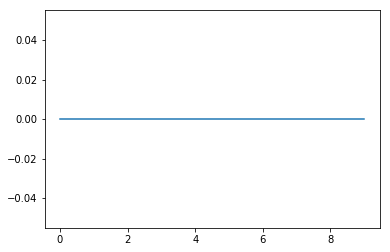

In [79]:
plt.plot([metrics.accuracy_score(y_Above_test[yColumns].values.ravel(), np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Automatically created module for IPython interactive environment


C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.

C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\i

C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\scott\Anaconda3\envs\fastai\lib\site-packages\i

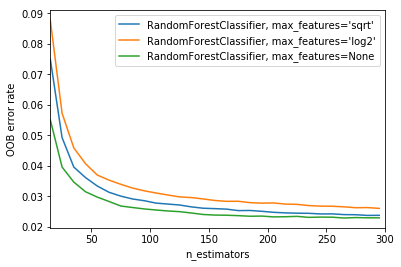

In [53]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
#X, y = make_classification(n_samples=500, n_features=25,
#                           n_clusters_per_class=1, n_informative=15,
#                           random_state=RANDOM_STATE)
X = X_Above_train
y = y_Above_train[yColumns]

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               n_jobs = 3,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               n_jobs = 3,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               n_jobs=3,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 300

for label, clf in ensemble_clfs:
    i = min_estimators
    for i in range(min_estimators, max_estimators + 1, 10):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
best_preds = [np.argmax(line) for line in resultAbove]

In [ ]:
best_preds_df = pd.DataFrame(best_preds, columns=['o_Day1DangerAboveTreeline'])

In [ ]:
best_preds_df.head()

In [ ]:
mapping = {0:'Considerable', 1:'High', 2:'Low', 3:'Moderate'}
best_preds_df = best_preds_df.replace({'o_Day1DangerAboveTreeline': mapping})
best_preds_df['o_Day1DangerAboveTreeline'].head()

In [ ]:
evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], best_preds_df)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], best_preds_df)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
importances = pd.Series(gbmgpu.feature_importances_)
out = pd.concat([pd.Series(X_Above_train.columns), importances], axis=1)

In [ ]:
out.columns = ['feature', 'importance']

In [ ]:
out.sort_values('importance',ascending=False)[:100]